- dgenerator
- date: 2020-08-06
- maintainer: YZK

In [1]:
# %%bash
# jupyter nbconvert --to script dgenerator.ipynb

In [5]:
import logging
import os
import re
import sys
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
from sklearn import preprocessing

try:
    thisd = os.path.dirname(os.path.realpath(__file__))
    sys.path.append(thisd)
    from mdfloader import Dataset
    from parallel import runFunctionsInParallel
    from textloader import textloader 
except Exception as E:
    logging.warning(E)
    if __name__ == "__main__":
        from mdfloader import Dataset
        from parallel import runFunctionsInParallel
        from textloader import textloader    
    else:
        from lib.mdfloader import Dataset
        from lib.parallel import runFunctionsInParallel
        from lib.textloader import textloader

floader   = Dataset.floader
getGI     = Dataset.getGI
qcfparser = Dataset.qcfparser
getids    = textloader.get_id

In [6]:
def dtimeGenerator(tperiod, fmt):
    '''
        tperiod: [sdtime, edtime]
        fmt: "Ymd", "YmdH", "YmdHM"
        hour system: 00 ~ 23
    '''
    
    sdtime = datetime.strptime(str(tperiod[0]), fmt) 
    edtime = datetime.strptime(str(tperiod[1]), fmt)
    dtime_ = sdtime
    dtimes = []
    
    syr = sdtime.timetuple()[0]
    eyr = edtime.timetuple()[0]
    nyr = eyr - syr + 1
    
    if fmt == "%Y%m%d":
        idx2posi = np.ndarray((nyr, 366), dtype=np.int16)
    elif fmt == "%Y%m%d%H":
        idx2posi = np.ndarray((nyr, 366, 24), dtype=np.int16)
    elif fmt == "%Y%m%d%H%M":
        idx2posi = np.ndarray((nyr, 366, 24, 6), dtype=np.int16)

    idx2posi.fill(-999)
    
    posi = 0
    while dtime_ <= edtime:
        ttuple = dtime_.timetuple()
#         print(ttuple)
        dtimes.append(dtime_)
        if fmt == "%Y%m%d":
            dtime_ += timedelta(days=1)
            idx2posi[ttuple[0] - syr, ttuple[7]] = posi
        elif fmt == "%Y%m%d%H":
            dtime_ += timedelta(hours=1)
            idx2posi[ttuple[0] - syr, ttuple[7], ttuple[3]] = posi
        elif fmt == "%Y%m%d%H%M":
            dtime_ += timedelta(minutes=10)
            idx2posi[ttuple[0] - syr, ttuple[7], ttuple[3], int(ttuple[4] * 0.1)] = posi

        posi += 1
            
    return dtimes, idx2posi

In [7]:
class dgenerator():
    def __init__(self, resd=None, ind=None, cmpltd=None, npyd=None, parsed=None, vrange=None,
                 gif="stations.txt",
                 cwbfmt=".QPESUMS_STATION.10M.mdf",
                 autofmt=".QPESUMS_STATION.15M.mdf",
                 pfmt=".QPESUMS_STATION.txt"):
        
        self.ind     = ind
        self.cmpltd  = cmpltd
        self.npyd    = npyd
        self.parsed  = parsed
        self.cwbfmt  = cwbfmt
        self.autofmt = autofmt
        self.pfmt    = pfmt        
        self.stnids  = None
        self.nstn    = None
        
        if vrange is None:
            vrange = {"Temp": [-20.0, 50.0],
                      "RH": [0.0, 100.0],
                      "Pres": [600.0, 1100.0],
                      "Precp": [0.0, 220.0]}
    
        self.vrange = pd.DataFrame(vrange)

            
#         self.vnames = ["Temp", "RH", "Pres", "Precp"]
        self.vnames = self.vrange.columns.to_list()
        
        self.vname2abbr = {"Temp": "TT", 
                           "RH": "RH", 
                           "Pres": "PP", 
                           "Precp": "RR"}
        
        if resd is not None:
            try:
                self.raw_gi, self.stnids, self.nstn = getGI("{0}/{1}".format(resd, gif))
            except Exception as E:
                logging.warning("dgenerator-23: {}".format(E))
                self.stnids = getids("{0}/{1}".format(resd, gif))
                self.nstn   = len(self.stnids)
        else:
            try:
                self.stnids = getids("{0}".format(gif))
                self.nstn   = len(self.stnids)
            except Exception as E:
                logging.warning("dgenerator-31: {}".format(E))
                self.raw_gi, self.stnids, self.nstn = getGI("{0}".format(gif))
        
    @property
    def stnids(self):    
        return self._stnids
        
    @stnids.setter
    def stnids(self, val):
        self._stnids = val
        
    @property
    def vrange(self):
        return self._vrange
    
    @vrange.setter
    def vrange(self, val):
        self.vnames = val.columns.to_list()
        self._vrange = val
    
    @vrange.deleter
    def vrange(self):
        del self._vrange
        print("dgenerator-35: self._vrange has been deleted.")
        
    @staticmethod
    def series_to_supervised(data, n_in=1, n_out=1, dropnan=True, vnames=None):

        '''
            convert series to supervised learning
            create a dataset with columns t - n_in, ..., t - 2, t - 1, t, t + 1, ..., t + (n_out - 1),
            if n_in = 2 and n_out = 2, then get a dataset with columns t - 2, t - 1, t, t + 1
        '''

        n_vars = 1 if type(data) is list else data.shape[1]

        if isinstance(data, pd.DataFrame):
            df = data
        else:
            df = pd.DataFrame(data)

        cols, names = list(), list()

        # input sequence (t-n_in, ..., t-1)
        for i in range(n_in, 0, -1):
            cols.append(df.shift(i))
            if vnames is not None and len(vnames) == n_vars:
                names += ["{0}(t-{1})".format(vname, i) for vname in vnames]
            else:
                names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]

        # forecast sequence (t, t+1, ..., t+n_out-1)
        for i in range(0, n_out):
            cols.append(df.shift(-i))
            if i == 0:
                if vnames is not None and len(vnames) == n_vars:
                    names += ["{0}(t)".format(vname) for vname in vnames]
                else:
                    names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
            else:
                if vnames is not None and len(vnames) == n_vars:
                    names += [("{0}(t+{1})".format(vname, i)) for vname in vnames]
                else:
                    names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

        # put it all together
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        # drop rows with NaN values
        if dropnan:
            agg.dropna(inplace=True)
        return agg
            
    @staticmethod
    def mdfinspector(ind, cwbfmt, autofmt, tperiod=None, qc_log=None, cmpltd=None, rtqc=False):

        '''
            check what time do mdf exist 
            tperiod: time period for inspecting mdf, a list like [stime, etime]
            cwbfmt: suffix of filename
            autofmt: suffix of filename
        '''
        
        if cmpltd is None:
            cmpltd = ind
        
        if tperiod is not None:
            if len(tperiod) == 1:
                qc_stime = datetime.strptime(str(tperiod[0]), "%Y%m%d%H%M")
                qc_etime = datetime.strptime(str(tperiod[0]), "%Y%m%d%H%M")
                tperiod.append(tperiod[0])
            elif len(tperiod) == 2:
                qc_stime = datetime.strptime(str(tperiod[0]), "%Y%m%d%H%M")
                qc_etime = datetime.strptime(str(tperiod[1]), "%Y%m%d%H%M")
            else:
                tperiod = None
                print("Warning-mdfinspector-178: time period is a list with length 2.")
                
        if tperiod is None:
            qc_stime = datetime.now() - timedelta(years=30)
            qc_etime = datetime.now()

        fnames = os.listdir(ind)
        fnames.sort()

        cwbfre = re.compile(pattern=r"^([0-9]{10})([0-9]{2})" + cwbfmt)
        autofre = re.compile(pattern=r"^([0-9]{10})([0-9]{2})" + autofmt)

        qcdtimes  = []  # a integer list

        dtnow = datetime.now()

        # check if cwb or auto exists (one of them)
        nf = 0
        for idx, tmp in enumerate(fnames):

            autofmatch = autofre.match(tmp)
            cwbfmatch = cwbfre.match(tmp)
            matched = False
            dtobj = None

            if autofmatch is not None:
                YYYYmmddHHMM = autofmatch.group(1) + autofmatch.group(2)
                if int(YYYYmmddHHMM) not in qcdtimes:
                    if os.path.isfile("{}/{}{}".format(ind, YYYYmmddHHMM, cwbfmt)) or os.path.isfile("{}/{}{}".format(cmpltd, YYYYmmddHHMM, cwbfmt)):  # check cwb
                        dtobj = datetime.strptime(YYYYmmddHHMM, "%Y%m%d%H%M")
            elif cwbfmatch is not None:
                YYYYmmddHHMM = cwbfmatch.group(1) + cwbfmatch.group(2)
                if int(YYYYmmddHHMM) not in qcdtimes:
                    if os.path.isfile("{}/{}{}".format(ind, YYYYmmddHHMM, autofmt)) or os.path.isfile("{}/{}{}".format(cmpltd, YYYYmmddHHMM, autofmt)):  # check cwb
                        dtobj = datetime.strptime(YYYYmmddHHMM, "%Y%m%d%H%M")

            if dtobj is not None:
                if rtqc:
                    if abs((dtnow - dtobj).total_seconds() / (60 * 60)) > (8 + 24):  # obs file is UTC time
                        continue
                    matched = True

                if tperiod is not None:                                              # check qc time period
                    if not (qc_stime <= dtobj and dtobj <= qc_etime):
                        continue
                    matched = True

                if matched:
                    qcdtimes.append(int(YYYYmmddHHMM))
                    if qc_log is not None:
                        nf += 1
                        qc_log.write("  {0:3d}. {1}\n".format(nf, YYYYmmddHHMM + cwbfmt))
                        nf += 1
                        qc_log.write("  {0:3d}. {1}\n".format(nf, YYYYmmddHHMM + autofmt))

        return sorted(set(qcdtimes))
    
    
    def hrfgenerator(self, tperiod, n_in=6, n_out=1, batchsize=24, mode="train", fnpy=True, rescale=True, reformat=True, vstack=True, dropnan=True, generator=False, classify=None):
        
        '''
            {mode} is just suffix of npy files, ex. mdf_{mode}.npy, qcdtime_{mode}.npy, stnid_{mode}.npy
            if {fnpy} is True, then load data from npy files
            if {generator} is True, then {batchesize} will be activated and get a iterator (generator)
            if {rescale} is True, then data will be normalized (StandardScaler). 
            if {rescale} is "MinMax", then use MinMaxScaler.
            if {reformat} is True, then data array will be reformatted by staticmethod "series_to_supervised" with arguments {n_in}, {n_out}
            if {vstack} is True, then observations of all stations (dim = (nsize, :)) will stack vertically (dim = (nsize * nstn, :))
            if {dropnan} is True, then data less than minimum in self.vrange will be set to np.nan and dropped if {vstack} is True
        '''
        
        ind        = self.ind
        npyd       = self.npyd
        stnids     = self.stnids
        nstn       = self.nstn
        vnames     = self.vnames
        vrange     = self.vrange
#         vnames_    = vrange.columns.tolist()
        vname2abbr = self.vname2abbr

#         assert vnames == vnames_
        
        logging.info("hrfgenerator-vnames-199: {}".format(vnames))

        if tperiod is not None:
            if len(tperiod) == 1:
                sdtime = tperiod[0]
                edtime = tperiod[0]
                tperiod.append(tperiod[0])
            elif len(tperiod) == 2:
                sdtime = tperiod[0]
                edtime = tperiod[1]
            else:
                tperiod = None
                logging.error("hrfgenerator-209: tperiod is None")
                sys.exit(-1)    

        if fnpy:
            if npyd is None:  
                logging.error("hrfgenerator-214: npyd is None")
                sys.exit(-1)
                
            darray   = np.load("{}/hrf_{}_{}_{}.npy".format(npyd, tperiod[0], tperiod[1], mode))
            qcdtimes = np.load("{}/qcdtime_{}_{}_{}.npy".format(npyd, tperiod[0], tperiod[1], mode), allow_pickle=True).tolist()
            stnids_  = np.load("{}/stnid_{}_{}_{}.npy".format(npyd, tperiod[0], tperiod[1], mode), allow_pickle=True).tolist()
            nsize    = len(qcdtimes)
            nstn_    = len(stnids_)
            
            if stnids is not None:
                assert stnids == stnids_
            else:
                stnids = stnids_
            
            if nstn is not None:
                assert nstn == nstn_
            else:
                nstn = nstn_
            
        else:
            if stnids is None or nstn is None:
                logging.error("hrfgenerator-220: stnids or nstn is None.")
                sys.exit(-1)
            
            obs = []

            for vname_ in vnames:
                vname = vname2abbr[vname_] if vname_ in vname2abbr.keys() else vname_
                ind_ = "{0}/{1}".format(ind, vname)
                obs_, stnid, YYYYmmddHH_, quantity = textloader.hrf(ind_, stnids, sdtime, edtime, hrfp="hr_{}".format(vname.lower()))
                logging.info("hrfgenerator-244: quantity of {}: {}".format(vname, quantity))
                YYYYmmddHH = YYYYmmddHH_
                obs.append(obs_.T)
            
            darray   = np.stack(obs, axis=2)
            nsize    = darray.shape[0]
            nstn     = darray.shape[1]
            qcdtimes = YYYYmmddHH
            stnids   = stnid
            
            if npyd is not None:
                np.save("{}/hrf_{}_{}_{}.npy".format(npyd, tperiod[0], tperiod[1], mode), arr=darray)
                np.save("{}/qcdtime_{}_{}_{}.npy".format(npyd, tperiod[0], tperiod[1], mode), arr=np.array(qcdtimes))
                np.save("{}/stnid_{}_{}_{}.npy".format(npyd, tperiod[0], tperiod[1], mode), arr=np.array(stnids))

        return dgenerator._dprocessing(darray, qcdtimes, stnids, vrange, n_in=n_in, n_out=n_out, batchsize=batchsize, rescale=rescale, reformat=reformat, vstack=vstack, dropnan=dropnan, generator=generator, classify=classify)

    
    def mdfgenerator(self, tperiod, n_in=6, n_out=1, batchsize=24, mode="train", fnpy=True, rescale=True, reformat=True, vstack=True, dropnan=True, generator=False, classify=None):

        '''
            {mode} is just suffix of npy files, ex. mdf_{mode}.npy, qcdtime_{mode}.npy, stnid_{mode}.npy
            if {fnpy} is True, then load data from npy files
            if {generator} is True, then {batchesize} will be activated and get a iterator (generator)
            if {rescale} is True, then data will be normalized (StandardScaler). 
            if {rescale} is "MinMax", then use MinMaxScaler.
            if {reformat} is True, then data array will be reformatted by staticmethod "series_to_supervised" with arguments {n_in}, {n_out}
            if {vstack} is True, then observations of all stations (dim = (nsize, :)) will stack vertically (dim = (nsize * nstn, :))
            if {dropnan} is True, then data less than minimum in self.vrange will be set to np.nan and dropped if {vstack} is True
        '''
        
        ind     = self.ind
        cmpltd  = self.cmpltd
        npyd    = self.npyd
        parsed  = self.parsed
        cwbfmt  = self.cwbfmt 
        autofmt = self.autofmt 
        pfmt    = self.pfmt
        stnids  = self.stnids
        nstn    = self.nstn
        vnames  = self.vnames
        vrange  = self.vrange
#         vnames_ = vrange.columns.tolist()
        
#         assert vnames == vnames_
        
        logging.info("mdfgenerator-vnames-290: {}".format(vnames))
        
        if tperiod is not None:
            if len(tperiod) == 1:
                sdtime = datetime.strptime(str(tperiod[0]), "%Y%m%d%H%M")
                edtime = datetime.strptime(str(tperiod[0]), "%Y%m%d%H%M")
                tperiod.append(tperiod[0])
            elif len(tperiod) == 2:
                sdtime = datetime.strptime(str(tperiod[0]), "%Y%m%d%H%M")
                edtime = datetime.strptime(str(tperiod[1]), "%Y%m%d%H%M")
            else:
                tperiod = None
                logging.error("mdfgenerator-303: tperiod is None.")
                sys.exit(-1)

        if fnpy:  # data from npy
            
            if npyd is None:  
                logging.error("mdfgenerator-309: npyd is None")
                sys.exit(-1)
                
            darray   = np.load("{}/mdf_{}_{}_{}.npy".format(npyd, tperiod[0], tperiod[1], mode))
            qcdtimes = np.load("{}/qcdtime_{}_{}_{}.npy".format(npyd, tperiod[0], tperiod[1], mode), allow_pickle=True).tolist()
            stnids_  = np.load("{}/stnid_{}_{}_{}.npy".format(npyd, tperiod[0], tperiod[1], mode), allow_pickle=True).tolist()
            
            nsize = len(qcdtimes)
            nstn_ = len(stnids_)  # it's a list
            
            if stnids is not None:
                assert stnids == stnids_
            else:
                stnids = stnids_
                
            if nstn is not None:
                assert nstn == nstn_
            else:
                nstn = nstn_
                
        else:    
            if stnids is None or nstn is None:
                logging.error("mdfgenerator-332: stnids or nstn is None.")
                sys.exit(-1)

            syr = sdtime.timetuple()[0]
            qcdtimes, idx2posi = dtimeGenerator([tperiod[0], tperiod[1]], fmt="%Y%m%d%H%M")
#             qcdtimes_ = dgenerator.mdfinspector(ind, cwbfmt, autofmt, tperiod=tperiod)
            nsize = len(qcdtimes)
            
            darray = np.ndarray(shape=(nsize, nstn, 4))  # Temp, RH, Pres, Precp
            darray.fill(-999)
        
            dtime_ = sdtime
            counts = 0
            jobs = []
            jnames = []

            while dtime_ <= edtime:
                dtime = dtime_.strftime("%Y%m%d%H%M")
                counts += 1
                jnames.append("{0:>04d}-{1}".format(counts, dtime))
                jobs.append([qcfparser, [dtime, [ind, cmpltd, parsed]], {"outdir": parsed}])  # don't output if outdir is None
                if dtime_ == edtime:
                    ret = runFunctionsInParallel(jobs, names=jnames, 
                                                 offsetsSeconds=0, maxAtOnce=None, 
                                                 parallel=True, allowJobFailure=True)
                    for qidx in range(counts):
                        id_     = ret[1][qidx][0]
                        array_  = ret[1][qidx][1]
                        chname_ = ret[1][qidx][2]
                        dt_     = ret[1][qidx][3]
                        ttuple_  = datetime.strptime(dt_, "%Y%m%d%H%M").timetuple()
                        if array_ is None:  # to take obs from parsed files in order to make a time series is continuous
                            pdarray = floader(parsed, "{}{}".format(dt_, pfmt))
                            if pdarray is None:
                                logging.warning("mdfgenerator-363: why array_ is None on {}?".format(dt_))
                                continue
                            id_     = pdarray[0:, 0]
                            array_  = pdarray[0:, 1:-1]
                            chname_ = pdarray[0:, -1]

                        dt_idx = idx2posi[ttuple_[0] - syr, ttuple_[7], ttuple_[3], int(ttuple_[4] * 0.1)]
                        logging.debug("ttuple: {}, idx: {}".format(ttuple_, dt_idx))
                        for wrow, mdfid in enumerate(id_):

                            if not (mdfid in stnids):
                               continue

                            id_idx = stnids.index(mdfid)
                            
#                             dt_idx = qcdtimes.index(int(dt_))

                            darray[dt_idx, id_idx, 0] = float(array_[wrow, 3])  # Temp
                            darray[dt_idx, id_idx, 1] = float(array_[wrow, 4])  # RH
                            darray[dt_idx, id_idx, 2] = float(array_[wrow, 5])  # Pres
                            darray[dt_idx, id_idx, 3] = float(array_[wrow, 6])  # Precp

                    counts = 0
                    jobs = []
                    jnames = []

                dtime_ = dtime_ + timedelta(minutes=10)
                
            if npyd is not None:
                np.save("{}/mdf_{}_{}_{}.npy".format(npyd, tperiod[0], tperiod[1], mode), arr=darray)
                np.save("{}/qcdtime_{}_{}_{}.npy".format(npyd, tperiod[0], tperiod[1], mode), arr=np.array(qcdtimes))
                np.save("{}/stnid_{}_{}_{}.npy".format(npyd, tperiod[0], tperiod[1], mode), arr=np.array(stnids))        
                
        return dgenerator._dprocessing(darray, qcdtimes, stnids, vrange, n_in=n_in, n_out=n_out, batchsize=batchsize, rescale=rescale, reformat=reformat, vstack=vstack, dropnan=dropnan, generator=generator, classify=classify)
            
    @staticmethod            
    def _dprocessing(darray, qcdtimes, stnids, vrange, n_in=6, n_out=1, batchsize=24, rescale=None, reformat=True, vstack=True, dropnan=True, generator=False, classify=None):
        
        '''
            - darray.shape = (nsize, nstn, nfeature (=4))
            
            - darray[:, :, idx]
            
                idx       |    0 |  1 |    2 |     3
             ------------------------------------------
                variable  | Temp | RH | Pres | Precp
                
                
            - classify: [[idx1, idx2, ...], [[values for classifing], [], ...]]
            ex.
                [[0, 3], [[-5, 0, 5, 10, 15], [0, 10, 20, 30, 40]]]
                0 to Temp, 3 to Precp
            
        '''
        
        vnames   = vrange.columns.to_list()
        nsize    = len(qcdtimes)
        nstn     = len(stnids)
        nfeature = len(vnames)
        
        if dropnan:
            for idx, vname in enumerate(vnames):
                logging.info("_dprocessing-408: drop missing values of {}".format(vname))
                darray[:, :, idx][np.where(darray[:, :, idx] < vrange[vname][0])] = np.nan           
                
                
        if classify is not None:
            
            vidx = classify[0]
            byv  = classify[1] 
            clsarray = np.ndarray((nsize, nstn, nfeature), dtype=np.int32)
            clsarray.fill(-999)
            
            for idx_, vidx_ in enumerate(vidx):
                for id_idx in range(nstn):
                    for which_class, v_ in enumerate(byv[idx_]):
                        d_ = darray[:, id_idx, vidx_]
                        if which_class == 0:
                            clsarray[np.where(d_ <= v_), id_idx, vidx_] = which_class
                            if which_class == len(byv[idx_]) - 1:
                                clsarray[np.where(d_ > v_), id_idx, vidx_] = which_class + 1
                        elif which_class == len(byv[idx_]) - 1:
                            clsarray[np.where((d_ > byv[idx_][which_class - 1]) & (d_ <= v_)), id_idx, vidx_] = which_class
                            clsarray[np.where(d_ > v_), id_idx, vidx_] = which_class + 1
                        else:
                            clsarray[np.where((d_ > byv[idx_][which_class - 1]) & (d_ <= v_)), id_idx, vidx_] = which_class
            
            
        ts2supervise = np.copy(darray)  # dim = [nsize, nstn, 4]
        
        rescaled = []
        if rescale is not None:
            if rescale == "MinMax":
                scaler = preprocessing.MinMaxScaler()
                scaler.fit(vrange.values)
            else:
                scaler = preprocessing.StandardScaler()
                scaler.fit(np.reshape(darray, (nsize * nstn, nfeature)))
                
            for id_idx, id_ in enumerate(stnids):
                rescaled.append(scaler.transform(darray[:, id_idx, :]))
                
            ts2supervise = np.stack(rescaled, axis=1)  # dim = [nsize, nstn, nfeature]
        else:    
            scaler = None
            for id_idx, id_ in enumerate(stnids):
                rescaled.append(darray[:, id_idx, :])
        
        reformated = []
        if reformat:
            for id_idx, id_ in enumerate(stnids):
                reformated.append(dgenerator.series_to_supervised(rescaled[id_idx], n_in=n_in, n_out=n_out, dropnan=False, vnames=vnames).values)  # dim(rescaled[id_idx]) = [nsize, (n_in + n_out) * nfeature]
            
            if vstack:
                
                if classify is not None:
                    clslist = []
                    for id_idx, id_ in enumerate(stnids):
                        clslist.append(clsarray[:, id_idx, :])
                    clsarray = np.vstack(clslist)  # dim = [nsize * nstn, nfeature]
                
                ts2supervise = np.vstack(reformated)  # dim = [nsize * nstn, (n_in + n_out) * nfeature]
                if dropnan:
                    if classify is not None:
                        logging.debug("shape of ts2supervise: {}, clsarray: {}, {}".format(ts2supervise.shape, clsarray.shape, ~np.isnan(ts2supervise).any(axis=1)))

                        clsarray = clsarray[~np.isnan(ts2supervise).any(axis=1)]
                    ts2supervise = ts2supervise[~np.isnan(ts2supervise).any(axis=1)]
                nsize_ = ts2supervise.shape[0]
                
            else:
                ts2supervise = np.stack(reformated, axis=1)  # dim = [nsize, nstn, (n_in + n_out) * nfeature]
                nsize_ = nsize
        
        def _diterator():
            # variables can still identify in this function scope
            while True:
                idx = np.random.choice(nsize_, batchsize, replace=False)
                if reformat:
                    if vstack:
                        yield ts2supervise[idx, :((-nfeature) * n_out)], ts2supervise[idx, ((-nfeature) * n_out):]
                    else:
                        yield ts2supervise[idx, :, :((-nfeature) * n_out)], ts2supervise[idx, :, ((-nfeature) * n_out):]

        if not generator:
            if classify is not None:
                return [ts2supervise, clsarray, qcdtimes, stnids, darray, scaler]

            return [ts2supervise, qcdtimes, stnids, darray, scaler]
        else:
            logging.info("_dprocessing-456: data generator has been built.")
            return _diterator()
        

In [8]:
if __name__ == "__main__":
    
    logging.getLogger().setLevel(logging.ERROR)
#     logging.getLogger().setLevel(logging.DEBUG)

    
    npyd    = "/home/yuzhe/DataScience/dataset"

    
    #     stninfo = "/home/yuzhe/CODE/ProgramT1/GRDTools/SRC/RES/GI/RR_analysis_grid_stationlist.txt"
    
###### 1. series_to_supervised
    df = pd.DataFrame({'Temp': [10, 20, 15, 30, 45],
                       'Pres': [1200, 1132, 990, 993, 1034],
                       'RH': [0.84, 0.77, 0.8, 0.75, 0.52]})
    print(df)

    pda = dgenerator.series_to_supervised(df, n_in=0, n_out=2, dropnan=False, vnames=['Temp', 'Pres', 'RH'])
    print(pda)
        
        
###### 2. vrange setter and vnames
    vrange = {"RH": [0, 100]}
    resd    = "/NAS-DS1515P/users1/T1/res"
    ind    = "/NAS-DS1515P/users1/realtimeQC/ftpdata"
    dg = dgenerator(resd=resd, ind=ind, npyd=npyd, vrange=vrange)

###### 3. mdf
    resd     = "/NAS-DS1515P/users1/T1/res"
    ind      = "/NAS-DS1515P/users1/realtimeQC/ftpdata"
    cmpltd   = ind
#     tperiod  = [201801010100, 202007312350]
    tperiod  = [202007310100, 202007310350]

    parsed   = "/home/yuzhe/DataScience/dataset/parsed"
    cwbfmt   = ".QPESUMS_STATION.10M.mdf"
    autofmt  = ".QPESUMS_STATION.15M.mdf"
    pfmt     = ".QPESUMS_STATION.txt"
    classify = [[3], [[0.1, 5, 10]]]
    
    dg1 = dgenerator(gif="{}/stations.txt".format(resd), ind=ind, npyd=npyd, cwbfmt=cwbfmt, autofmt=autofmt, pfmt=pfmt)
#     mdfs = dg1.mdfgenerator(tperiod, n_in=6, n_out=1, mode="train", rescale=True, reformat="MinMax", vstack=True, fnpy=False, generator=False)            
#     mdfs = dg1.mdfgenerator(tperiod, n_in=6, n_out=1, mode="train", rescale=True, reformat="MinMax", vstack=True, fnpy=False, generator=False, classify=classify)            
    
    dg1 = dgenerator(gif="{}/stations.txt".format(resd), ind=ind, npyd=None, cwbfmt=cwbfmt, autofmt=autofmt, pfmt=pfmt)
    mdfs = dg1.mdfgenerator(tperiod, n_in=6, n_out=1, mode="test", rescale=True, reformat="MinMax", vstack=False, fnpy=False, generator=False, classify=classify)            


###### 4. hrf
    ind      = "/NAS-129/users1/T1/DATA/YY/ORG/HR1"
    npyd     = "/home/yuzhe/DataScience/dataset"
    stninfo  = "/home/yuzhe/CODE/ProgramT1/GRDTools/SRC/RES/GI/1500_decode_stationlist_without_space.txt"
    tperiod  = [2012010101, 2015123124]
    tperiod  = [1998010101, 2015123124]

    classify = [[3], [[0.1, 5, 10, 20, 40]]]
    
    hrfdg = dgenerator(ind=ind, gif=stninfo, npyd=npyd, vrange={"RR": [0., 220.], "RH": [0., 100.]})
#     hrfs = hrfdg.hrfgenerator(tperiod, n_in=6, n_out=1, mode="testStandard", rescale="StandardScaler", reformat=True, vstack=False, fnpy=False, generator=False)
#     hrfs = hrfdg.hrfgenerator(tperiod, n_in=6, n_out=1, mode="RHPrecpMinMax", rescale="MinMax", reformat=True, vstack=True, fnpy=False, generator=False)
    
    vrange = {"Temp": [-20.0, 50.0],
              "RH": [0.0, 100.0],
              "Pres": [600.0, 1100.0],
              "Precp": [0.0, 220.0]}
    
    hrfdg.vrange = pd.DataFrame(vrange)
    
#     hrfs = hrfdg.hrfgenerator(tperiod, n_in=6, n_out=1, mode="trainMinMax", rescale="MinMax", reformat=True, vstack=False, fnpy=False, generator=False, classify=classify)

    tperiod  = [2016010101, 2018123124]
#     hrfs = hrfdg.hrfgenerator(tperiod, n_in=6, n_out=1, mode="testMinMax", rescale="MinMax", reformat=True, vstack=False, fnpy=False, generator=False)

    

###### 5. check npy
#     arr = np.load("{}/hrf_2016010101_2016123124_testMinMax.npy".format(npyd))
#     arr = np.load("{}/hrf_2012010101_2015123124_trainStandard.npy".format(npyd))

    

   Temp  Pres    RH
0    10  1200  0.84
1    20  1132  0.77
2    15   990  0.80
3    30   993  0.75
4    45  1034  0.52
   Temp(t)  Pres(t)  RH(t)  Temp(t+1)  Pres(t+1)  RH(t+1)
0       10     1200   0.84       20.0     1132.0     0.77
1       20     1132   0.77       15.0      990.0     0.80
2       15      990   0.80       30.0      993.0     0.75
3       30      993   0.75       45.0     1034.0     0.52
4       45     1034   0.52        NaN        NaN      NaN


In [20]:
int(mdfs[2][0].strftime("%Y%m%d%H%M"))

202007310100

[   0.0,    0.1],  0.914105 15932321 17429424
(   0.1,    5.0],  0.073212 1276050 17429424
(   5.0,   10.0],  0.006681 116439 17429424
(  10.0,   20.0],  0.003885 67716 17429424
(  20.0,   40.0],  0.001730 30151 17429424
(  40.0,    inf),  0.000387 6747 17429424


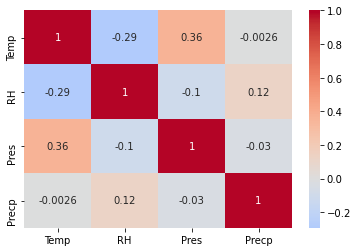

In [101]:

if __name__ == "__main__":
    
###### check precp distribution
    
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns

    npyd = "../dataset/hrf_2012010101_2015123124_trainMinMax.npy"
    hrd  = np.load(npyd)  # [nsize, nstn, 4]

    precp = np.reshape(hrd[:, :, -1], (-1, 1))

    v = [0.1, 5, 10, 20, 40,]
    n = precp[np.where(precp >= 0)].shape[0]
    for idx_, v_ in enumerate(v):
        if idx_ == 0:
            n_ = precp[np.where((0 <= precp) & (precp <= v_))].shape[0]
            print("[{0:>6.1f}, {1:>6.1f}], {2:9.6f} {3} {4}".format(0, v_, n_ / n, n_, n))
        elif idx_ == len(v) - 1:
            n_ = precp[np.where((v[idx_ - 1] < precp) & (precp <= v_))].shape[0]
            print("({0:>6.1f}, {1:>6.1f}], {2:9.6f} {3} {4}".format(v[idx_ - 1], v_, n_ / n, n_, n))
            n_ = precp[np.where(v_ < precp)].shape[0]
            print("({0:>6.1f},    inf), {1:9.6f} {2} {3}".format(v_, n_ / n, n_, n))
        else:
            n_ = precp[np.where((v[idx_ - 1] < precp) & (precp <= v_))].shape[0]
            print("({0:>6.1f}, {1:>6.1f}], {2:9.6f} {3} {4}".format(v[idx_ - 1], v_, n_ / n, n_, n))

            
###### correlations

    reformat = np.reshape(hrd, (-1, 4))
    reformat[np.where(reformat < -90.)] = np.nan

    df = pd.DataFrame(reformat, columns=["Temp", "RH", "Pres", "Precp"])
    corrMatrix = df.corr()
    sns.heatmap(corrMatrix, annot=True, center=0, cmap="coolwarm")

######  pair plot

#     idnpyd = "../dataset/stnid_2012010101_2015123124_trainMinMax.npy"
#     stnids  = np.load(npyd)
#     nstn = len(stnids)

#     for idx, id_ in enumerate(stnids):
#         df = hrd[:, idx, :]
#         df = pd.DataFrame(df, columns=["Temp", "RH", "Pres", "Precp"])
#     #     g = pd.plotting.scatter_matrix(df, figsize=(10, 10), marker='o', hist_kwds={'bins': 10}, s=60, alpha=0.8)
#         sns.pairplot(df)
#         plt.show()

In [267]:
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from collections import deque, Counter


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  del sys.path[0]


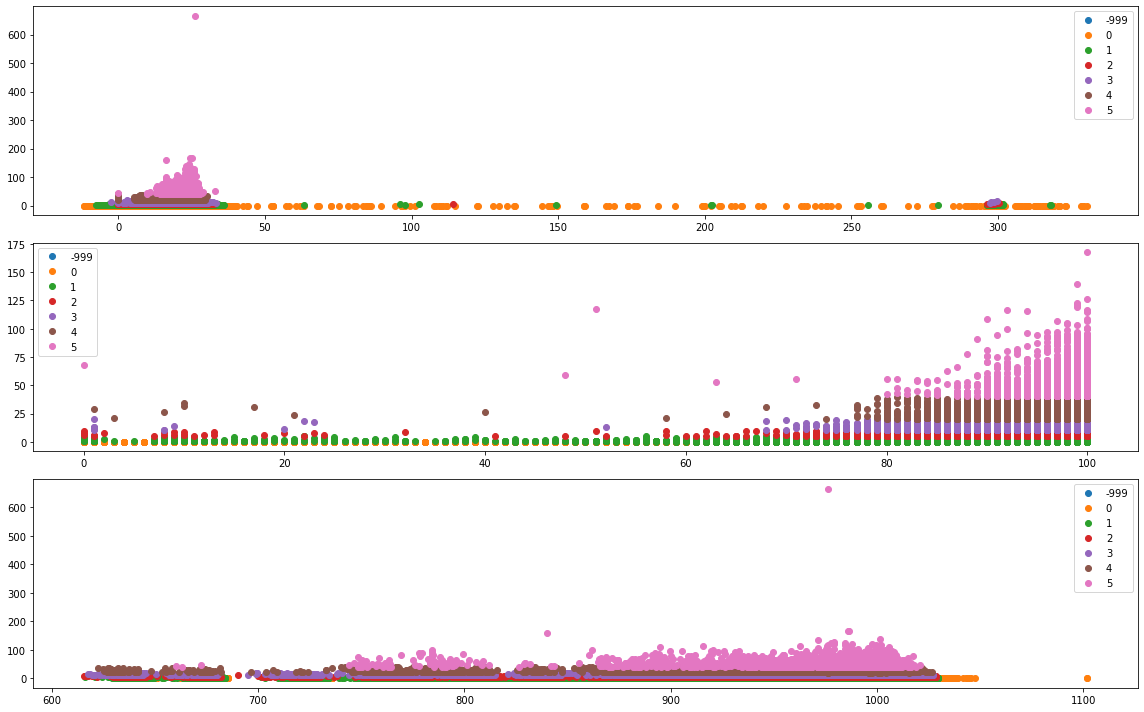

In [262]:
rawdata = np.reshape(hrfs[-2], (-1, 4))
labels = np.reshape(hrfs[1], (-1, 4))

fig, ax = plt.subplots(3, figsize=(16, 10))
for vidx in range(3):
    df = pd.DataFrame(dict(x=rawdata[:, vidx], y=rawdata[:, 3], label=labels[:, 3]))
    grps = df.groupby("label")
    for gname, grp in grps:
        ax[vidx].plot(grp.x.values, grp.y.values, marker="o", linestyle="", label=gname)
        
    ax[vidx].legend()
    
plt.tight_layout()
plt.show()

In [250]:
print(labels.shape)
rawdata.shape

labels[:, 3]
stacked = np.hstack([rawdata, np.reshape(labels[:, 3], (-1, 1))])
stacked = stacked[~np.isnan(stacked).any(axis=1)]

np.unique(stacked[:, -1])

In [ ]:
# X_resampled, y_resampled = SMOTE().fit_resample(stacked[:, 0:-1], stacked[:, -1])
X_resampled, y_resampled = BorderlineSMOTE().fit_resample(stacked[:, 0:-1], stacked[:, -1])

In [258]:
print(sorted(Counter(y_resampled).items()))

[(0.0, 7205336), (1.0, 7205336), (2.0, 7205336), (3.0, 7205336), (4.0, 7205336), (5.0, 7205336)]


In [265]:
X_resampled.shape

(43232016, 4)

In [ ]:
fig, ax = plt.subplots(3, figsize=(16, 10))
for vidx in range(3):
    df = pd.DataFrame(dict(x=X_resampled[:, vidx], y=X_resampled[:, 3], label=y_resampled))
    grps = df.groupby("label")
    for gname, grp in grps:
        ax[vidx].plot(grp.x.values, grp.y.values, marker="o", linestyle="", label=gname)
        
    ax[vidx].legend()
    
plt.tight_layout()
plt.show()

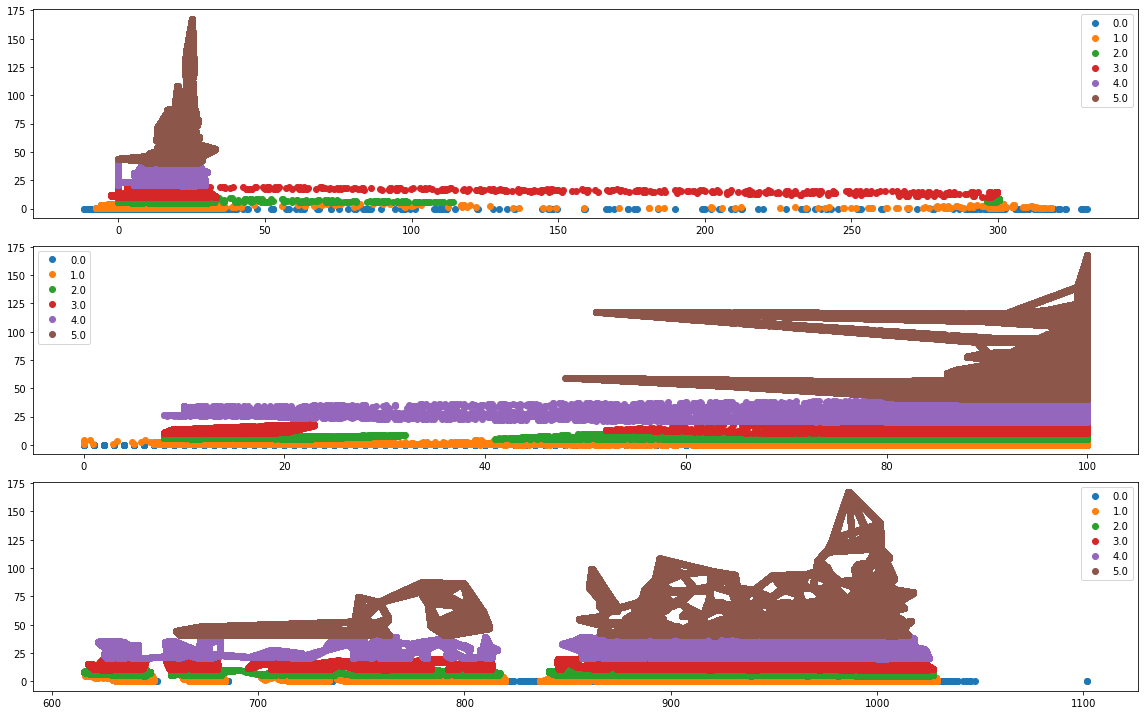

In [266]:
fig, ax = plt.subplots(3, figsize=(16, 10))
for vidx in range(3):
    df = pd.DataFrame(dict(x=X_resampled[:, vidx], y=X_resampled[:, 3], label=y_resampled))
    grps = df.groupby("label")
    for gname, grp in grps:
        ax[vidx].plot(grp.x.values, grp.y.values, marker="o", linestyle="", label=gname)
        
    ax[vidx].legend()
    
plt.tight_layout()
plt.show()

In [42]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([8.999e+03, 3.400e+01, 2.000e+01, 8.000e+00, 7.000e+00, 2.000e+00,
        6.000e+00, 6.000e+00, 3.000e+00, 4.000e+00]),
 array([ 0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. , 22.5, 25. ]),
 <a list of 10 Patch objects>)

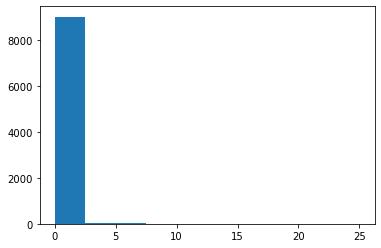

In [43]:
precp = mdfs[-2][:, :, 3]
precp = np.reshape(precp, (-1, 1))
plt.hist(precp)

In [54]:
encd = OneHotEncoder().fit([["precp<=0.1", 0], ["0.1<precp<=5", 1], ["5<precp", 2]])
# encd = OneHotEncoder().fit([0, 1, 2])

In [72]:
encd.fit_transform(np.reshape(mdfs[1][:, 3], (-1, 1)))

<5602x3 sparse matrix of type '<class 'numpy.float64'>'
	with 5602 stored elements in Compressed Sparse Row format>